# PPO

In this notebook, we will implementa basic PPO Reinforcement learning algorithm for Lunar Lander Environment.

## Lunar Lander

This environment is a classic rocket trajectory optimization problem. The landing pad is always at coordinates (0,0). The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

There are four discrete actions available:<br>
- 0: do nothing<br>
- 1: fire left orientation engine<br>
- 2: fire main engine<br>
- 3: fire right orientation engine<br>

After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.

- is increased/decreased the slower/faster the lander is moving.

- is decreased the more the lander is tilted (angle not horizontal).

- is increased by 10 points for each leg that is in contact with the ground.

- is decreased by 0.03 points each frame a side engine is firing.

- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.

An episode is considered a solution if it scores at least 200 points.


You can read more the cartpole environment [here](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

![Cartpole](https://gymnasium.farama.org/_images/lunar_lander.gif)

## PPO

PPO is motivated by the same question as TRPO: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? Where TRPO tries to solve this problem with a complex second-order method, PPO is a family of first-order methods that use a few other tricks to keep new policies close to old. PPO methods are significantly simpler to implement, and empirically seem to perform at least as well as TRPO.

There are two primary variants of PPO: PPO-Penalty and PPO-Clip.

**PPO-Penalty** approximately solves a KL-constrained update like TRPO, but penalizes the KL-divergence in the objective function instead of making it a hard constraint, and automatically adjusts the penalty coefficient over the course of training so that it's scaled appropriately.

**PPO-Clip** doesn't have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.

Read more [here](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

Here, we'll focus only on PPO-Clip.

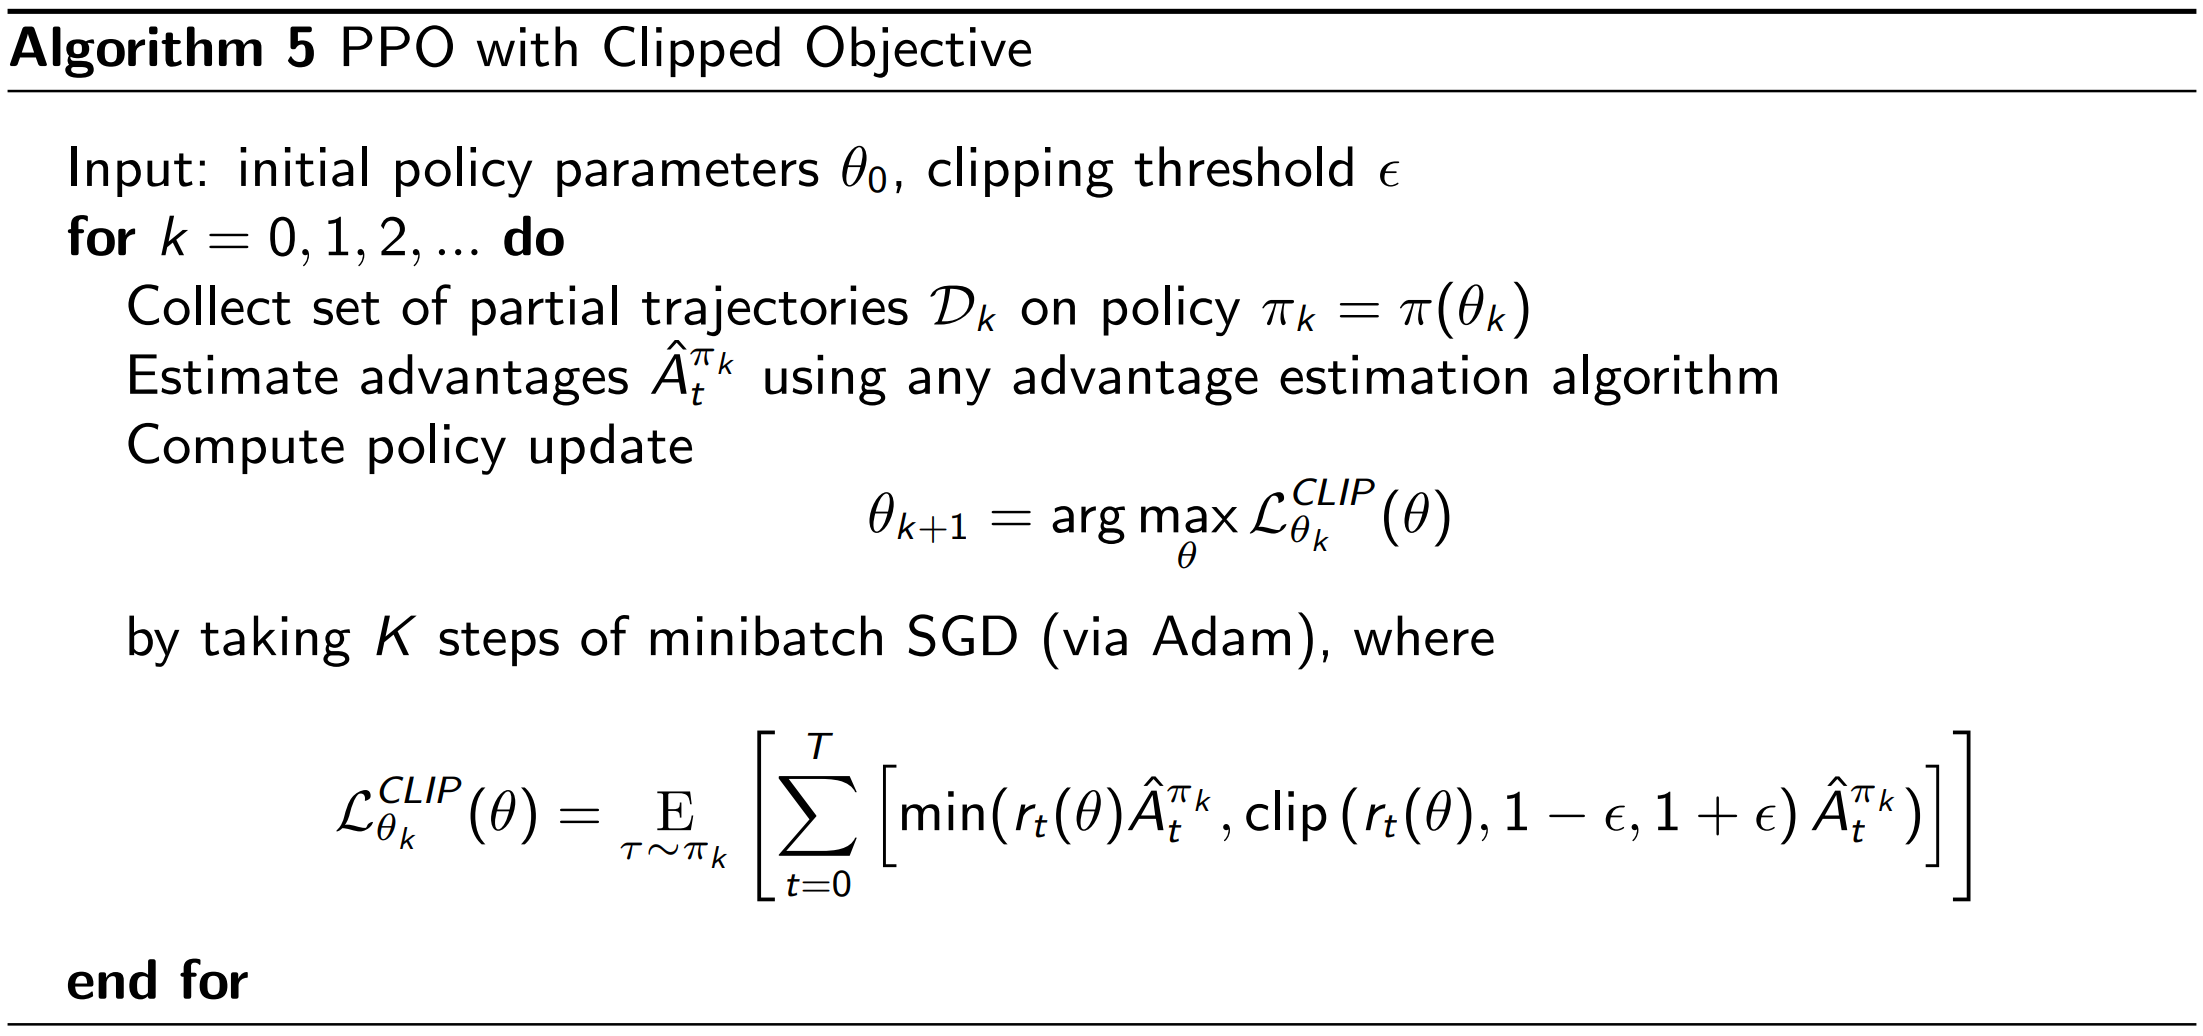

In [1]:
!pip install -q swig
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.4 MB/s eta 0:00:00


In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

In [3]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Create the environment
env = gym.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Rollout Buffer

In [7]:
# Buffer to store trajectories
class RolloutBuffer:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.state_values = []
    self.is_terminals = []

  def clear(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.state_values[:]
    del self.is_terminals[:]

### PPO Network

In [33]:
class PPO(nn.Module):
    """
    PPO is an actor critic method. Here we will implement both actor and critic in one model
    """
    def __init__(self, n_observations, n_actions):
      super(PPO, self).__init__()
      self.affine1 = nn.Linear(n_observations, 128)

      # actor's layer
      self.action_head = nn.Linear(128, n_actions)

      # critic's layer
      self.value_head = nn.Linear(128, 1)

    def forward(self, x):
      """
      forward of both actor and critic
      """
      x = F.relu(self.affine1(x))

      # actor: choses action to take from state s_t
      # by returning probability of each action
      action_prob = F.softmax(self.action_head(x), dim=-1)

      # critic: evaluates being in the state s_t
      state_values = self.value_head(x)

      # return values for both actor and critic as a tuple of 2 values:
      # 1. a list with the probability of each action over the action space
      # 2. the value from state s_t
      return action_prob, state_values

    def act(self, state):
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      with torch.no_grad():
        probs, state_value = self.forward(state)
      # create a categorical distribution over the list of probabilities of actions
      m = Categorical(probs)
      # and sample an action using the distribution
      action = m.sample()
      return action, m.log_prob(action), state_value.squeeze(0)

    def evaluate(self, state, action):
      """
      Evaluate state action according to current policy
      """
      probs, state_value = self.forward(state)
      m = Categorical(probs)

      action_logprobs = m.log_prob(action)
      dist_entropy = m.entropy()

      return action_logprobs, state_value, dist_entropy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Hyperparameters

In [45]:
# Here, we will specify the hyperparameters

total_episodes = 1000        # Total training episodes
max_steps = 500              # Max steps per episode
learning_rate = 1e-3         # Learning rate
gamma = 0.99                 # Discounting rate
train_freq = 5               # update policy every n timesteps
K_epochs = 10                # update policy for K epochs
eps_clip = 0.2               # clip parameter for PPO

### Training

In [46]:
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('state size:', state_size)
print('action size:', action_size)

observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
action space: Discrete(4)
state size: 8
action size: 4


In [47]:
# Intialize policy network
agent = PPO(state_size, action_size).to(device)

# set up the optimizer
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

In [48]:
scores = []
buffer = RolloutBuffer()
for episode in range(1, total_episodes+1):
  saved_log_probs = []
  rewards = []
  state = env.reset()
  # collect trajectory
  for t in range(max_steps):
    # sample action and its log probability from policy
    action, log_prob, value = agent.act(state)
    state, reward, done, _ = env.step(action.item())

    # Saving in buffer
    buffer.states.append(torch.FloatTensor(state).to(device))
    buffer.actions.append(action)
    buffer.logprobs.append(log_prob)
    buffer.state_values.append(value)
    buffer.rewards.append(reward)
    buffer.is_terminals.append(done)

    rewards.append(reward)

    if done:
        break

  scores.append(sum(rewards))

  if episode % train_freq == 0:
    # Compute the discounted returns at each timestep
    returns = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.is_terminals)):
      if is_terminal:
        discounted_reward = 0
      discounted_reward = reward + (gamma * discounted_reward)
      returns.insert(0, discounted_reward)

    # Normalizing the returns
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-7)

    # convert list to tensor
    old_states = torch.squeeze(torch.stack(buffer.states, dim=0)).detach().to(device)
    old_actions = torch.squeeze(torch.stack(buffer.actions, dim=0)).detach().to(device)
    old_logprobs = torch.squeeze(torch.stack(buffer.logprobs, dim=0)).detach().to(device)
    old_state_values = torch.squeeze(torch.stack(buffer.state_values, dim=0)).detach().to(device)

    # calculate advantages
    advantages = returns.detach() - old_state_values.detach()

    # Optimize policy for K epochs
    for _ in range(K_epochs):
      # Evaluating old actions and values
      logprobs, state_values, dist_entropy = agent.evaluate(old_states, old_actions)

      # match state_values tensor dimensions with returns tensor
      state_values = torch.squeeze(state_values)

      # Finding the ratio (pi_theta / pi_theta__old)
      ratios = torch.exp(logprobs - old_logprobs.detach())

      # Finding Surrogate Loss
      surr1 = ratios * advantages
      surr2 = torch.clamp(ratios, 1-eps_clip, 1+eps_clip) * advantages

      # final loss of clipped objective PPO
      loss = -torch.min(surr1, surr2) + 0.5 * F.smooth_l1_loss(state_values, returns) - 0.01 * dist_entropy

      # take gradient step
      optimizer.zero_grad()
      loss.mean().backward()
      optimizer.step()


    # clear buffer
    buffer.clear()


  print(f"Episode {episode}: Reward = {scores[-1]}")


Episode 1: Reward = -103.93644013320117
Episode 2: Reward = -395.87644568879034
Episode 3: Reward = -156.98035320846438
Episode 4: Reward = -49.51421669585312
Episode 5: Reward = -352.29738018600915
Episode 6: Reward = -233.21117346969905
Episode 7: Reward = -107.3037036969955
Episode 8: Reward = -195.93561693252008
Episode 9: Reward = -147.63207486413836
Episode 10: Reward = -250.15302269277396
Episode 11: Reward = -56.58505645265436
Episode 12: Reward = -249.93160469605598
Episode 13: Reward = -395.4914955362507
Episode 14: Reward = -303.7756695777203
Episode 15: Reward = -357.4052605332378
Episode 16: Reward = -372.95647041865146
Episode 17: Reward = -435.4428494808425
Episode 18: Reward = -88.9682898583153
Episode 19: Reward = -151.28191723256361
Episode 20: Reward = -159.5741968869034
Episode 21: Reward = -50.5286855853898
Episode 22: Reward = -378.2444908386583
Episode 23: Reward = -212.84081139621074
Episode 24: Reward = -223.0277612765965
Episode 25: Reward = -316.3069551860120

Text(0, 0.5, 'Reward')

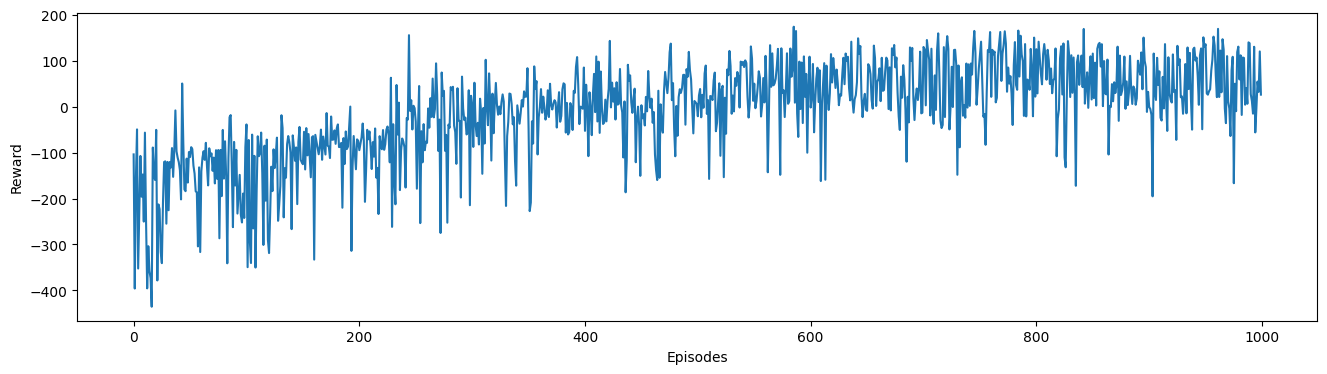

In [49]:
plt.figure(figsize=(16,4))
plt.plot(scores)
plt.xlabel("Episodes")
plt.ylabel("Reward")

### Visualization

In [50]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [51]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    for t in range(max_steps):
        vid.capture_frame()
        action, _, _ = agent.act(state)
        next_state, reward, done, info = env.step(action.item())
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()

In [58]:
show_video_of_model("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [59]:
show_video("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
